## 0. Librerias

In [106]:
!pip install matplotlib
import matplotlib.pyplot as plt

import sys
import os

!pip install pandas
import pandas as pd

!pip install nltk
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración

from collections import Counter

  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.5 MB ? eta -:--:--  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.2 MB/s  0:00:00
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [nltk]━━━━━━ 4/5 [nltk]b]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [nltk]


## 1. Carga y lectura de datos

Cargamos desde la función utils el dataset y hacemos una pequeña exploración del corpus para ver un poco la estructura del contenido, el tamaño y el balanceo de reviews.

In [86]:
# Asegurar que importamos el utils.py de la carpeta Project
project_path = os.path.dirname(os.path.abspath('__file__'))
if project_path not in sys.path:
    sys.path.insert(0, project_path)

from utils import load_beauty_reviews

In [87]:
# Path al directorio donde tenemos los datasets con las reviews
datasets_path = 'Data'
corpus_beauty_folder = 'All_Beauty.jsonl'

In [88]:
reviews_dict = load_beauty_reviews(datasets_path, corpus_beauty_folder)

In [89]:
print(len(reviews_dict))

701528


In [90]:
print(reviews_dict.get(1045))

{'rating': 3.0, 'title': "Good moisturizer but didn't perform as promised", 'text': "We all know about this issue so I figured I would give it a shot, why not right? Well sadly I was not too impressed to be honest. My rear was nicely moisturized for sure but I didn't really see any improvement in regards to acne and blackheads to be honest. It was worth a shot though but it does work quite nicely as a moisturizer but there are other, cheaper products for that that I like better tbh. At least it wasn't greasy so you could go on your merry day right away.", 'images': [], 'asin': 'B08WRMK4WG', 'parent_asin': 'B08WRMK4WG', 'user_id': 'AEZP6Z2C5AVQDZAJECQYZWQRNG3Q', 'timestamp': 1646151981492, 'helpful_vote': 0, 'verified_purchase': False}


In [91]:
# Extraer todos los ratings
ratings = [review['rating'] for review in reviews_dict.values()]

# Calcular min y max para saber escala de valoraciones
print(f"Rating mínimo: {min(ratings)}")
print(f"Rating máximo: {max(ratings)}")

Rating mínimo: 1.0
Rating máximo: 5.0


In [92]:
# Calcular porcentaje de cada valor de rating
rating_counts = Counter(ratings)
total = len(ratings)

print("Distribución de ratings:\n")
for rating in sorted(rating_counts.keys()):
    count = rating_counts[rating]
    percentage = (count / total) * 100
    print(f"Rating {rating}: {count:,} reviews ({percentage:.2f}%)")

Distribución de ratings:

Rating 1.0: 102,080 reviews (14.55%)
Rating 2.0: 43,034 reviews (6.13%)
Rating 3.0: 56,307 reviews (8.03%)
Rating 4.0: 79,381 reviews (11.32%)
Rating 5.0: 420,726 reviews (59.97%)


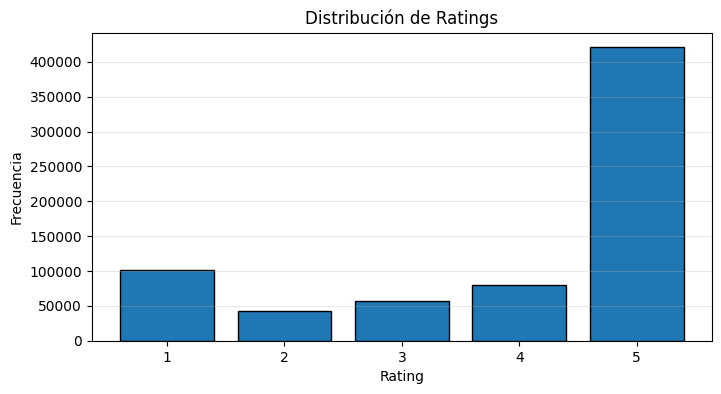

In [93]:
# Crear histograma de ratings
plt.figure(figsize=(8, 4))
plt.hist(ratings, bins=range(1, 7), edgecolor='black', align='left', rwidth=0.8)
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de Ratings')
plt.xticks(range(1, 6))
plt.grid(axis='y', alpha=0.3)
plt.show()

#### El corpus esta muy desbalanceado. Me quedo con un total de 10000 reviews equidistribuidas. Lo hago para facilitar el entrenamiento posterior de los modelos desde el punto de vista didactico. 

In [94]:
# Filtrar 2000 reviews de cada rating (total 10000)
from collections import defaultdict
import random

# Agrupar reviews por rating
reviews_by_rating = defaultdict(list)
for idx, review in reviews_dict.items():
    rating = review['rating']
    reviews_by_rating[rating].append((idx, review))

# Seleccionar 2000 de cada rating
all_selected = []
for rating in sorted(reviews_by_rating.keys()):
    selected = reviews_by_rating[rating][:2000]
    all_selected.extend(selected)

# Desordenar las reviews
random.shuffle(all_selected)

# Crear nuevo diccionario con índices consecutivos
balanced_reviews = {}
for new_idx, (old_idx, review) in enumerate(all_selected):
    balanced_reviews[new_idx] = review

# Reemplazar el diccionario original
reviews_dict = balanced_reviews
print(f"Total de reviews seleccionadas con distribución balanceada: {len(reviews_dict)}")

Total de reviews seleccionadas con distribución balanceada: 10000


In [95]:
reviews_text = []
reviews_rating = []

for review in reviews_dict.values():
    reviews_text.append(review.get('text'))
    reviews_rating.append(review.get('rating'))

df = pd.DataFrame({
    'review': reviews_text,
    'sentiment': reviews_rating
})
df.dropna(subset=['review', 'sentiment'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [96]:
df.head()

,review,sentiment
0,I like this moisturizer from MD Complete. It c...,4.0
1,I put it on using a stencil and liked the resu...,3.0
2,"Very light scent, that fades 5 minutes after a...",2.0
3,Flimsy bases.,3.0
4,This is a crap product.<br />1: The dont stick...,1.0


#### Convierto el corpus a minusculas y separo por palabras

In [97]:
splitted_reviews = df['review'].str.lower().str.split()

In [98]:
splitted_reviews

0       [i, like, this, moisturizer, from, md, complet...
1       [i, put, it, on, using, a, stencil, and, liked...
2       [very, light, scent,, that, fades, 5, minutes,...
3                                        [flimsy, bases.]
4       [this, is, a, crap, product.<br, />1:, the, do...
                              ...                        
9995    [i, would, recommend, these, brushes., i, have...
9996    [not, really, like, the, picture., there, were...
9997    [these, headbands, are, fantastic., there, are...
9998    [good, idea,, but, the, pillow, was, not, well...
9999    [i, have, very, dry, skin, and, i, love, how, ...
Name: review, Length: 10000, dtype: object

In [99]:
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

#### Cardinalidad del vocabulario:
Cuento el número de tokens(palabras en este caso) que componen el vocabulario y cuales son los que más aparecen

In [100]:
vocabulary_ = Counter(words)
len(vocabulary_)

32573

In [102]:
vocabulary_.most_common(10)

[('the', 22625),
 ('i', 17713),
 ('and', 15059),
 ('a', 14028),
 ('it', 13557),
 ('to', 13207),
 ('is', 9367),
 ('this', 8144),
 ('my', 7577),
 ('of', 7536)]

Son palabras que no estan aportando para un análisis de sentimiento y por tanto podría eliminarlas ocn un stopwords

#### N-grams más frecuentes:


In [107]:
bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

In [108]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [112]:
bigrams_freq_.most_common(10)

[(('of', 'the'), 1605),
 (('it', 'is'), 1596),
 (('i', 'have'), 1557),
 (('in', 'the'), 1342),
 (('is', 'a'), 1312),
 (('this', 'is'), 1217),
 (('on', 'the'), 1006),
 (('and', 'the'), 929),
 (('i', 'was'), 919),
 (('and', 'i'), 888)]

In [110]:
trigrams_freq_.most_common(10)

[(('this', 'is', 'a'), 435),
 (('a', 'lot', 'of'), 281),
 (('it', 'is', 'a'), 223),
 (('i', 'had', 'to'), 183),
 (('if', 'you', 'have'), 170),
 (('i', 'have', 'to'), 162),
 (('i', 'like', 'the'), 159),
 (('it', 'is', 'not'), 155),
 (('it', 'has', 'a'), 154),
 (('i', 'love', 'the'), 139)]

In [128]:
bg_freq_most_common = bigrams_freq_.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = trigrams_freq_.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

In [129]:
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

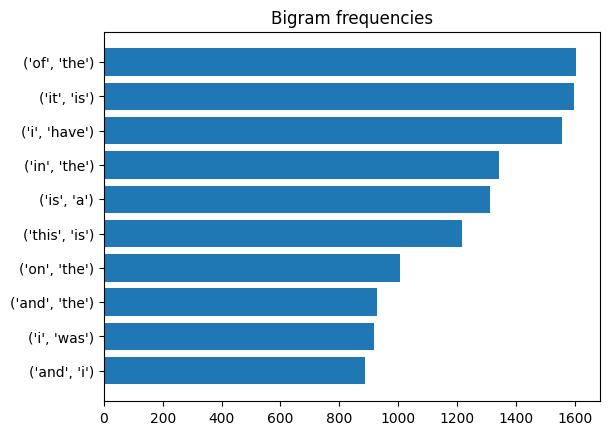

In [130]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

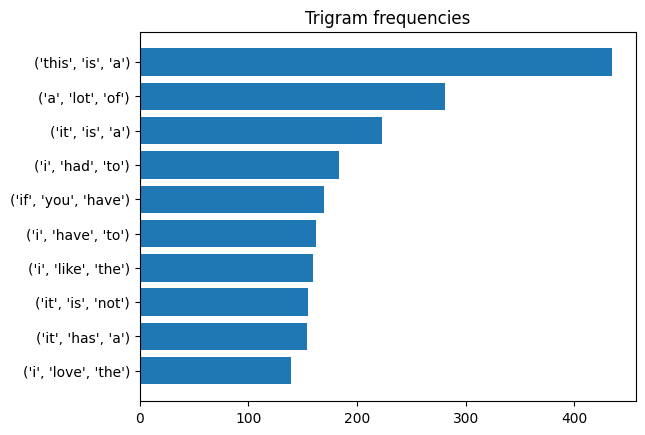

In [131]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

Parece que no es útil aplicar a todas las palabras el stopwords. Vemos que para los 3-grams hay combinaciones que si son importantes. Palabras como : `like` , `love` o `not` aportan información valiosa del sentimiento y conviene visualizar si estan incluidas en el stopwords y mantenerlas.

#### Nube de palabras:


In [141]:
!pip install wordcloud
from wordcloud import WordCloud

In [142]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

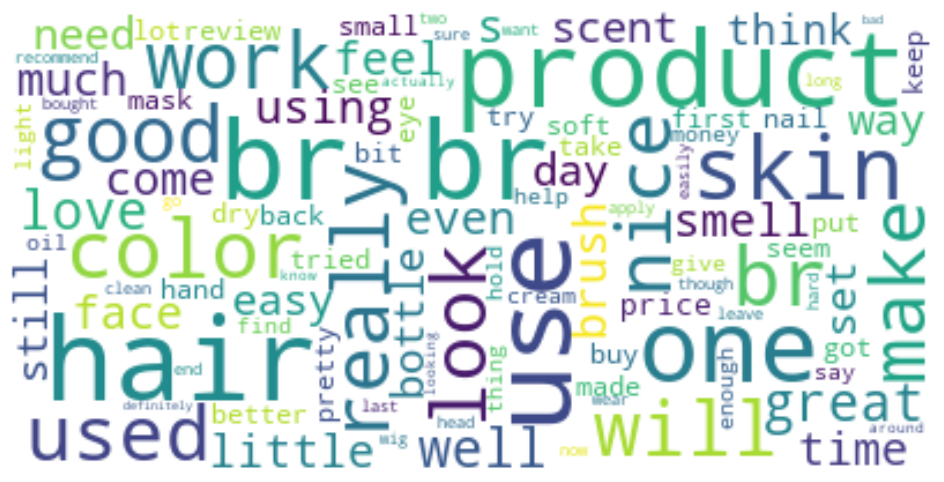

In [143]:
plot_word_cloud(words)

#### La palabra `<br, />`se repite mucho por lo que sería interesante aplicar BeautifulSoup en el preprocesado para eliminar cualquier tipo de etiqueta HTLM

## Visualización 2d de word embeddings

In [145]:
!pip install gensim scikit-learn
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

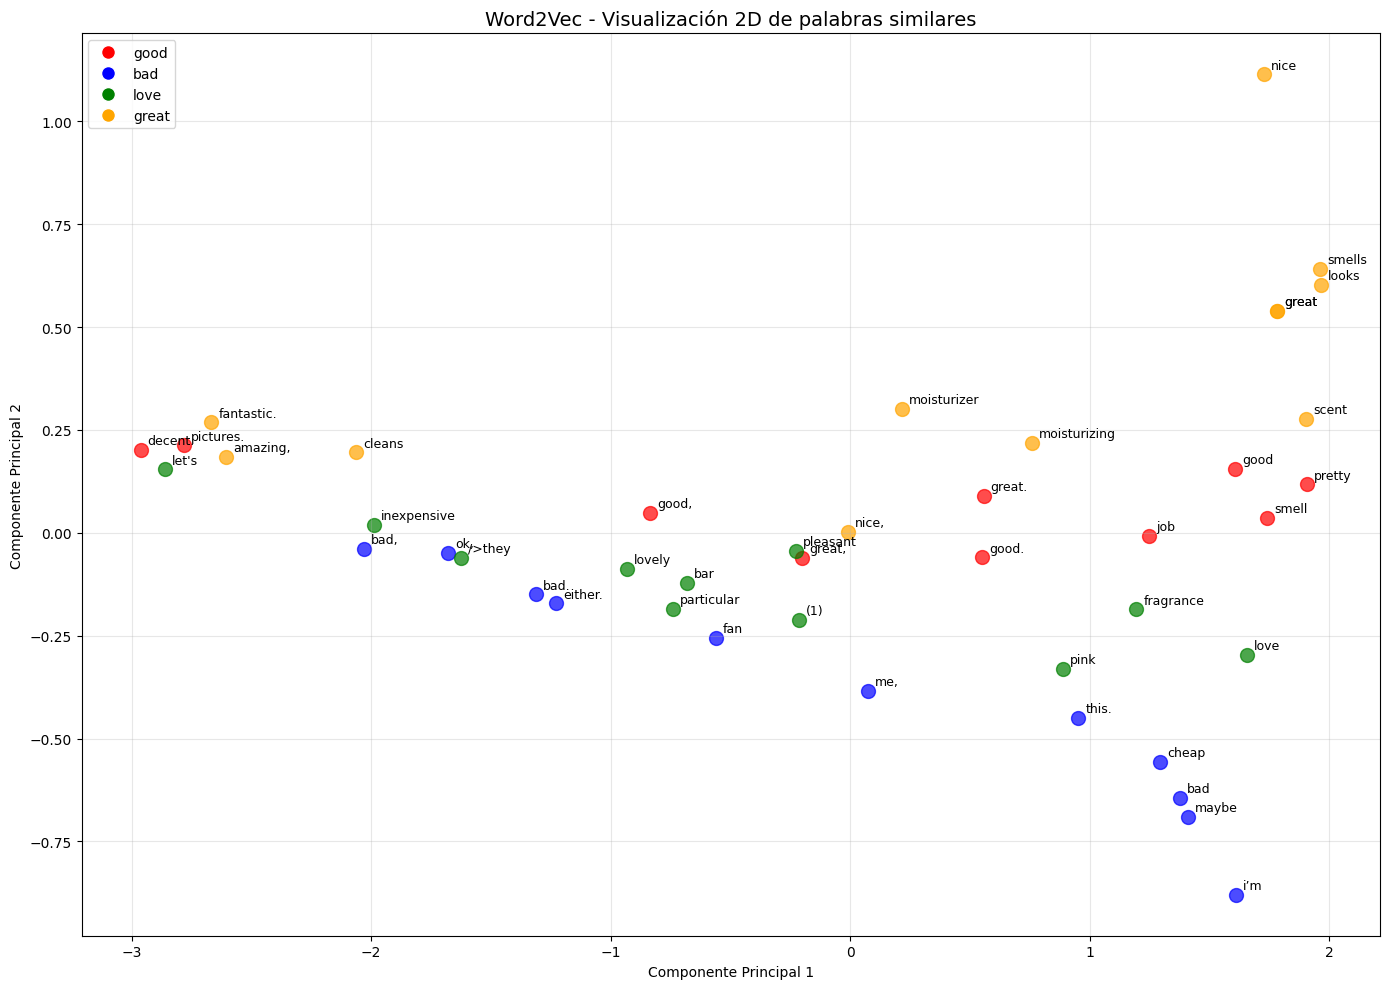

In [146]:
# Entrenar modelo Word2Vec
model = Word2Vec(sentences=splitted_reviews_filtered.tolist(), 
                 vector_size=100, 
                 window=5, 
                 min_count=2, 
                 workers=4)

# Palabras de interés para análisis de sentimiento
words_to_plot = ['good', 'bad', 'love', 'great']

# Obtener palabras similares y preparar datos para visualización
all_words = []
word_vectors = []

for word in words_to_plot:
    if word in model.wv:
        # Agregar la palabra principal
        all_words.append(word)
        word_vectors.append(model.wv[word])
        
        # Agregar las 10 más similares
        similar_words = model.wv.most_similar(word, topn=10)
        for similar_word, score in similar_words:
            all_words.append(similar_word)
            word_vectors.append(model.wv[similar_word])

# Reducir dimensionalidad con PCA
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Crear visualización
plt.figure(figsize=(14, 10))

# Definir colores para cada palabra principal
colors = ['red', 'blue', 'green', 'orange']
color_map = {}

idx = 0
for i, main_word in enumerate(words_to_plot):
    if main_word in model.wv:
        # Color para palabra principal
        color_map[all_words[idx]] = colors[i]
        
        # Mismo color para sus similares (11 palabras: principal + 10 similares)
        for j in range(11):
            if idx < len(all_words):
                color_map[all_words[idx]] = colors[i]
                idx += 1

# Plotear palabras
for i, word in enumerate(all_words):
    x, y = word_vectors_2d[i]
    plt.scatter(x, y, c=color_map[word], s=100, alpha=0.7)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), 
                textcoords='offset points', ha='left', va='bottom',
                fontsize=9)

# Personalizar el gráfico
plt.title('Word2Vec - Visualización 2D de palabras similares', fontsize=14)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True, alpha=0.3)

# Leyenda
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=colors[i], markersize=10, 
                              label=words_to_plot[i]) 
                   for i in range(len(words_to_plot)) if words_to_plot[i] in model.wv]
plt.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

# stopword a preprocesado

In [ ]:
!pip install spacy
from spacy.lang.en.stop_words import STOP_WORDS


In [118]:
print(list(STOP_WORDS)[:20])

['show', 'also', 'as', 'elsewhere', 'move', 'front', 'fifteen', 'me', 'really', 'all', 'she', 'twenty', 'empty', 'put', 'whence', 'during', 'various', 'up', 'others', 'give']


In [ ]:
len(list(STOP_WORDS))

326

In [122]:
# Visualizar las stopwords
print(f"Total de stopwords: {len(STOP_WORDS)}\n")
print("Lista de stopwords:")
print(sorted(list(STOP_WORDS)))

Total de stopwords: 326

Lista de stopwords:
["'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'by', 'ca', 'call', 'can', 'cannot', 'could', 'did', 'do', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'ha

In [123]:
# Identificar stopwords que pueden influir en el análisis de sentimiento
sentiment_relevant_stopwords = [
    'not', 'no', 'nor', 'never', 'neither', 'nobody', 'nothing', 'nowhere',
    'n\'t', 'cannot', 'without',  # Negación
    'but', 'however', 'although', 'though',  # Contraste
    'always', 'never', 'often', 'sometimes',  # Frecuencia
]

# Verificar cuáles están en STOP_WORDS
present_in_stopwords = [word for word in sentiment_relevant_stopwords if word in STOP_WORDS]
not_in_stopwords = [word for word in sentiment_relevant_stopwords if word not in STOP_WORDS]

print(f"Palabras relevantes para sentimiento que SÍ están en stopwords:")
print(sorted(present_in_stopwords))
print(f"\nPalabras relevantes para sentimiento que NO están en stopwords:")
print(sorted(not_in_stopwords))

Palabras relevantes para sentimiento que SÍ están en stopwords:
['although', 'always', 'but', 'cannot', 'however', "n't", 'neither', 'never', 'never', 'no', 'nobody', 'nor', 'not', 'nothing', 'nowhere', 'often', 'sometimes', 'though', 'without']

Palabras relevantes para sentimiento que NO están en stopwords:
[]


In [125]:
# Crear un set de stopwords personalizado excluyendo palabras relevantes
custom_stopwords = STOP_WORDS.copy()
for word in present_in_stopwords:
    custom_stopwords.discard(word)

# Aplicar filtrado de stopwords
def remove_stopwords(text_list):
    """Elimina stopwords excepto las relevantes para sentimiento"""
    return [word for word in text_list if word not in custom_stopwords]

# Aplicar a todas las reviews
splitted_reviews_filtered = splitted_reviews.apply(remove_stopwords)
splitted_reviews_filtered

0       [like, moisturizer, md, complete., comes, nice...
1       [stencil, liked, result., hair, red, brown., s...
2       [light, scent,, fades, 5, minutes, applying., ...
3                                        [flimsy, bases.]
4       [crap, product.<br, />1:, dont, stick, face, a...
                              ...                        
9995    [recommend, brushes., haven't, makeup, don't, ...
9996    [not, like, picture., 4, thicker, curls, need,...
9997    [headbands, fantastic., 9, set, come, variety,...
9998    [good, idea,, but, pillow, not, made., seal, b...
9999    [dry, skin, love, moisturizes., skin, soft, wi...
Name: review, Length: 10000, dtype: object

#  Distribución de reviews:
Etiqueto las reviews como:
- `0`: las menores de 3
- `1`: las mayor o igual a 3

In [81]:
def label_sentiment(row):
    if int(row['sentiment']) < 3:
        return 1
    else:
        return 0

In [82]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [83]:
df.head()

,review,sentiment,sentiment_label
0,eco friendly and very soft,5.0,0
1,I am in my early fifties and my morning skinca...,4.0,0
2,"Great exfoliant, but could probably be made at...",3.0,0
3,average,2.0,1
4,This shea butter is a good quality shea butter...,4.0,0


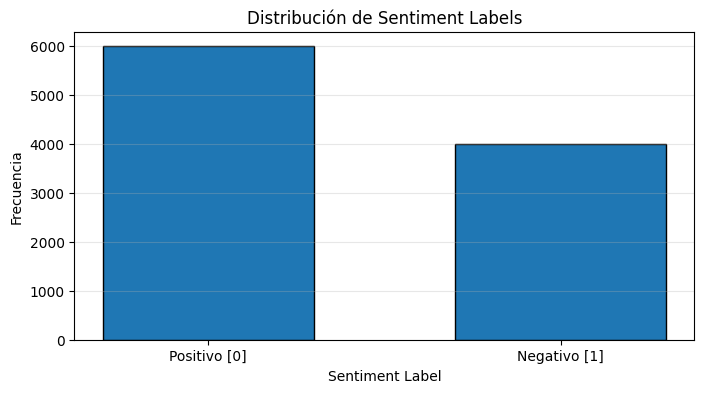

In [85]:
# Histograma de sentiment_label
plt.figure(figsize=(8, 4))
sentiment_counts = df['sentiment_label'].value_counts().sort_index()
plt.bar(sentiment_counts.index, sentiment_counts.values, edgecolor='black', width=0.6)
plt.xlabel('Sentiment Label')
plt.ylabel('Frecuencia')
plt.title('Distribución de Sentiment Labels')
plt.xticks([0, 1], ['Positivo [0]', 'Negativo [1]'])
plt.grid(axis='y', alpha=0.3)
plt.show()